### ordination to pull out fractions containing labeled OTUs

In [1]:
from pandas import DataFrame, get_dummies
import statsmodels.api as sm
from statsmodels.sandbox.regression.try_catdata import cat2dummy
from IPython.display import FileLink

In [2]:
%pylab inline
%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%R
library(phyloseq)
library(vegan)
library(ggplot2)
library(foreach)
library(doParallel)
library(plyr)
library(gridExtra)
library(RColorBrewer)
library(lattice)

Loading required package: permute
Loading required package: lattice
This is vegan 2.2-1
foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid


###First let's look at the <sup>13</sup>C cellulose versus control comparison. 

In [4]:
%%R
physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.SS = prune_samples((physeq.md$Treatment %in% c("12CCSS","13CCSS"))& (physeq.md$Day == 30) &
                          !(row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq)
physeq.SS.snorm = transform_sample_counts(physeq.SS, function(x) x/sum(x))
physeq.SS.thresh = filter_taxa(physeq.SS.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.SS)
print(physeq.SS.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1421 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 1421 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1421 tips and 1420 internal nodes ]


### Calculate pairwise weighted unifrac distances between samples.

In [5]:
%%R
registerDoParallel(cores=10)
wunif.dist = distance(physeq.SS.thresh, 
                weighted = TRUE, 
                fast = TRUE, 
                normalized = FALSE, 
                parallel = TRUE)

###Ordinate using weighted unifrac distances with NMDS.

In [6]:
%%R
nmds = ordinate(physeq.SS.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.06235117 
Run 1 stress 0.06333465 
Run 2 stress 0.06642816 
Run 3 stress 0.06386286 
Run 4 stress 0.0888319 
Run 5 stress 0.08849888 
Run 6 stress 0.06381577 
Run 7 stress 0.06549852 
Run 8 stress 0.06375983 
Run 9 stress 0.0875882 
Run 10 stress 0.06386291 
Run 11 stress 0.06517471 
Run 12 stress 0.06448298 
Run 13 stress 0.06235138 
... procrustes: rmse 9.757617e-05  max resid 0.0004490894 
*** Solution reached


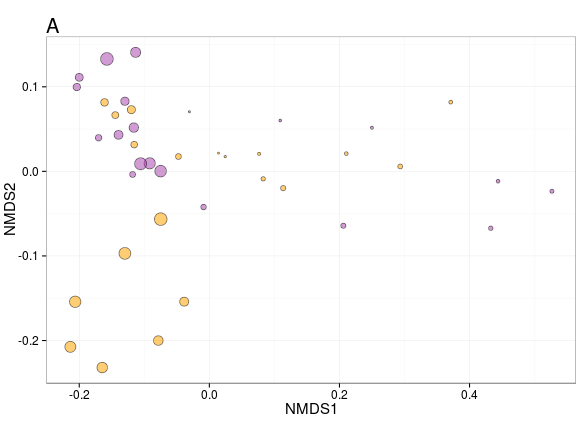

In [7]:
%%R -w 8 -h 6 -u in

colours = c("#ac4aaf","orange")

df = plot_ordination(physeq.SS.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p1 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p1 = p1 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p1 = p1 + scale_fill_manual(values = colours,
                            breaks=c("12CCSS", "13CCSS"),
                            labels=c("Control", "Cellulose Only"))
p1 = p1 + guides(alpha = FALSE)
p1 = p1 + scale_size_area(aesthetics = "Density")
p1 = p1 + ggtitle("A")
p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))
p1 = p1 + theme_bw()
p1 = p1 + theme(legend.position = "none")
p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = 0, size = 20))
p1 = p1 + theme(axis.title.x = element_text(size=15))
p1 = p1 + theme(axis.title.y = element_text(size=15))
p1 = p1 + theme(axis.text.x = element_text(size=12))
p1 = p1 + theme(axis.text.y = element_text(size=12))

p1

### Do the same for 13CCPS at D30

In [8]:
%%R
physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PS = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS"))& (physeq.md$Day == 30) &
                          !(row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq)
physeq.PS.snorm = transform_sample_counts(physeq.PS, function(x) x/sum(x))
physeq.PS.thresh = filter_taxa(physeq.PS.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PS)
print(physeq.PS.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1022 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 1022 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1022 tips and 1021 internal nodes ]


In [9]:
%%R
registerDoParallel(cores=10)
wunif.dist = distance(physeq.PS.thresh, 
                weighted = TRUE, 
                fast = TRUE, 
                normalized = FALSE, 
                parallel = TRUE)

In [10]:
%%R
nmds = ordinate(physeq.PS.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.05130933 
Run 1 stress 0.09202856 
Run 2 stress 0.08376639 
Run 3 stress 0.05152359 
... procrustes: rmse 0.01057021  max resid 0.04635546 
Run 4 stress 0.04719349 
... New best solution
... procrustes: rmse 0.01805032  max resid 0.04977401 
Run 5 stress 0.07586889 
Run 6 stress 0.04719272 
... New best solution
... procrustes: rmse 0.0002693468  max resid 0.0009831438 
*** Solution reached


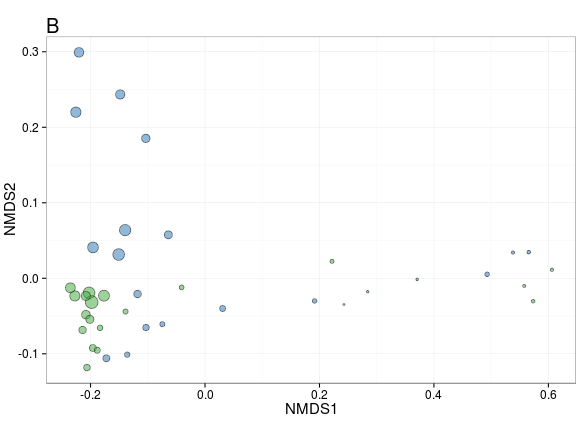

In [11]:
%%R -w 8 -h 6 -u in

colours = c("#4daf4a", "#377eb8")

df = plot_ordination(physeq.PS.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p2 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p2 = p2 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p2 = p2 + scale_fill_manual(values = colours,
                           breaks=c("12CCPS", "13CCPS"),
                            labels=c("Control", "C Mixture"))
p2 = p2 + guides(alpha = FALSE)
p2 = p2 + scale_size_area(aesthetics = "Density")
p2 = p2 + ggtitle("B")
#p2 = p2 + guides(fill = guide_legend(override.aes = list(size = 4)))
#p2 = p2 + guides(size = guide_legend(override.aes = list(fill = "black")))
p2 = p2 + theme_bw()
p2 = p2 + theme(legend.position = "none")
p2 = p2 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p2 = p2 + theme(plot.title = element_text(hjust = 0, size = 20))
p2 = p2 + theme(axis.title.x = element_text(size=15))
p2 = p2 + theme(axis.title.y = element_text(size=15))
p2 = p2 + theme(axis.text.x = element_text(size=12))
p2 = p2 + theme(axis.text.y = element_text(size=12))

p2

### All treatments at D30

In [12]:
%%R
physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.all = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS","12CCSS","13CCSS"))& (physeq.md$Day %in% c(30)) &
                          !(row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq)
physeq.all.snorm = transform_sample_counts(physeq.all, function(x) x/sum(x))
physeq.all.thresh = filter_taxa(physeq.all.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.all)
print(physeq.all.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1220 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 1220 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1220 tips and 1219 internal nodes ]


In [13]:
%%R
registerDoParallel(cores=10)
wunif.dist = distance(physeq.all.thresh, 
                weighted = TRUE, 
                fast = TRUE, 
                normalized = FALSE, 
                parallel = TRUE)

In [14]:
%%R
nmds = ordinate(physeq.all.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.08691032 
Run 1 stress 0.08683153 
... New best solution
... procrustes: rmse 0.01054961  max resid 0.07945493 
Run 2 stress 0.105536 
Run 3 stress 0.4096549 
Run 4 stress 0.1015518 
Run 5 stress 0.1027059 
Run 6 stress 0.09083142 
Run 7 stress 0.1075126 
Run 8 stress 0.09688119 
Run 9 stress 0.08647687 
... New best solution
... procrustes: rmse 0.004775426  max resid 0.02629826 
Run 10 stress 0.1066667 
Run 11 stress 0.1041512 
Run 12 stress 0.09688117 
Run 13 stress 0.08683123 
... procrustes: rmse 0.01209653  max resid 0.07947091 
Run 14 stress 0.1023209 
Run 15 stress 0.1085041 
Run 16 stress 0.1044133 
Run 17 stress 0.09828219 
Run 18 stress 0.1039127 
Run 19 stress 0.08647592 
... New best solution
... procrustes: rmse 7.452584e-05  max resid 0.0003102252 
*** Solution reached


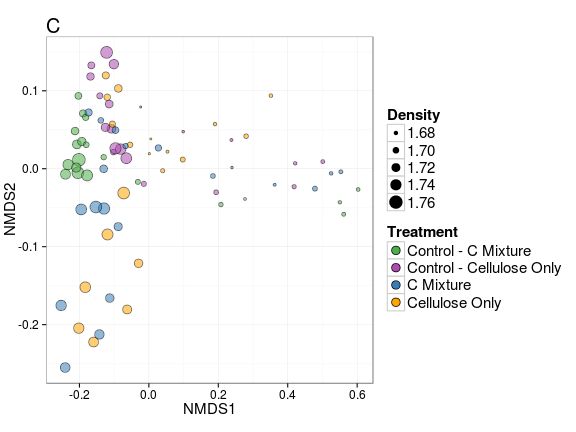

In [15]:
%%R -w 8 -h 6 -u in

colours = c("#4daf4a","#ac4aaf","#377eb8","orange")

df = plot_ordination(physeq.all.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p3 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p3 = p3 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p3 = p3 + scale_fill_manual(values = colours,
                            breaks=c("12CCPS", "12CCSS", "13CCPS", "13CCSS"),
                            labels=c("Control - C Mixture", "Control - Cellulose Only", 
                                     "C Mixture", "Cellulose Only"))
p3 = p3 + guides(alpha = FALSE)
p3 = p3 + scale_size_area(aesthetics = "Density")
p3 = p3 + ggtitle("C")
p3 = p3 + guides(fill = guide_legend(override.aes = list(size = 4)))
p3 = p3 + guides(size = guide_legend(override.aes = list(fill = "black")))
p3 = p3 + theme_bw()
p3 = p3 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p3 = p3 + theme(plot.title = element_text(hjust = 0, size = 20))
p3 = p3 + theme(axis.title.x = element_text(size=15))
p3 = p3 + theme(axis.title.y = element_text(size=15))
p3 = p3 + theme(axis.text.x = element_text(size=12))
p3 = p3 + theme(axis.text.y = element_text(size=12))
p3 = p3 + theme(legend.title = element_text(size = 15), legend.text = element_text(size = 15))

p3

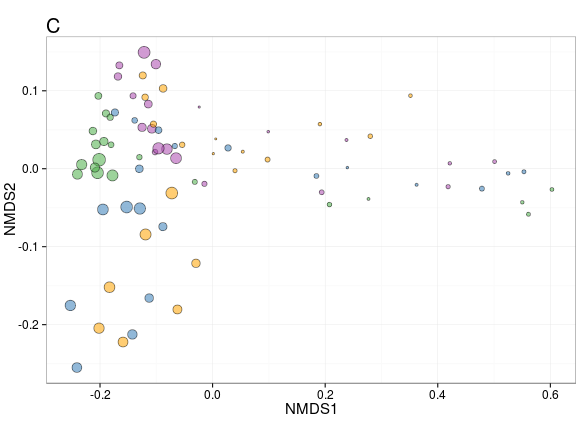

In [16]:
%%R -w 8 -h 6 -u in

p4 = p3 + theme(legend.position = "none")
p4

In [17]:
%%R
get_legend = function(myggplot){
  tmp <- ggplot_gtable(ggplot_build(myggplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}

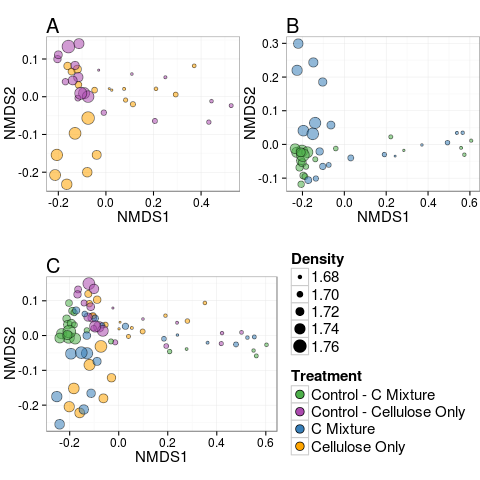

In [18]:
%%R

grid.newpage()
pushViewport(viewport(layout = grid.layout(20, 4)))
#vplayout = function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

define_region = function(row, col){
  viewport(layout.pos.row = row, layout.pos.col = col)
} 

#legend = ggplotGrob(p3)
#gp3 = ggplot_gtable(ggplot_build(p3))
#legend = ggplotGrob(gp3)
legend = get_legend(p3)
legend = editGrob(legend, vp = define_region(11:20, 4))

print(p1, vp = define_region(1:10, 1:2))
print(p2, vp = define_region(1:10, 3:4))
print(p3, vp = define_region(11:20, 1:4))
#grid.draw(legend)
#print(legend, vp = define_region(1:6, 5))

In [19]:
%%R
png("figs/ordination_allpanels.png", w = 10, h = 10, units = "in", res = 600)
pushViewport(viewport(layout = grid.layout(20, 4)))
print(p1, vp = define_region(1:10, 1:2))
print(p2, vp = define_region(1:10, 3:4))
print(p3, vp = define_region(11:20, 1:4))
#grid.draw(legend)
dev.off()

png 
  2 


In [20]:
FileLink("figs/ordination_allpanels.png")

/home/ashley/single_substrate/figs/ordination_allpanels.png